In [37]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
from sklearn.tree import DecisionTreeClassifier

from frouros.datasets.synthetic import SEA
from frouros.detectors.concept_drift import DDM, DDMConfig
from frouros.metrics.prequential_error import PrequentialError

In [38]:
random_state = 31

concept_samples = 20000
generator = SEA(seed=random_state)
noise = 0.0

reference_concept = generator.generate_dataset(
    block=1,  # Concept 1
    noise=noise,
    num_samples=concept_samples,
)

X_reference, y_reference = [], []
for sample, label in reference_concept:
    X_reference.append(sample)
    y_reference.append(label)
X_reference, y_reference = np.array(X_reference), np.array(y_reference).reshape(-1, 1)

## Shuffle data to avoid bias
idx = np.arange(len(X_reference))
np.random.shuffle(idx)
X_reference, y_reference = X_reference[idx], y_reference[idx]

split_idx = concept_samples // 2  # 10000 each subset (train and warmup)
X_train, y_train = X_reference[:split_idx], y_reference[:split_idx]
X_warmup, y_warmup = X_reference[split_idx:], y_reference[split_idx:]

In [39]:
test_concepts = [
    generator.generate_dataset(
        block=block,
        noise=noise,
        num_samples=10000,
    )
    for block in [1, 3]
]  # Concepts 1 and 3

X_test, y_test = [], []
for concept in test_concepts:
    for sample, label in concept:
        X_test.append(sample)
        y_test.append(label)

X_test, y_test = np.array(X_test), np.array(y_test).reshape(-1, 1)

In [40]:
config = DDMConfig(
    warning_level=2.0,
    drift_level=3.0,
    min_num_instances=len(
        X_warmup
    ),  # Minimum number of instances to start checking for drift
)

detector = DDM(
    config=config,
)

In [41]:
model = DecisionTreeClassifier(
    random_state=random_state,
)
model.fit(
    X=X_train,
    y=y_train,
)

DecisionTreeClassifier(random_state=31)

In [42]:
metrics = [
    PrequentialError(
        alpha=alpha,
        name=f"α={alpha}",
    )
    for alpha in [1.0, 0.9999, 0.999]
]
metrics_historic_detector = {f"{metric.name}": [] for metric in metrics}

In [43]:
metrics_historic_detector

{'α=1.0': [], 'α=0.9999': [], 'α=0.999': []}

In [44]:
def error_scorer(y_true, y_pred):  # Error function
    return 1 - (y_true.item() == y_pred.item())

In [45]:
# Warm-up detector
print(f"Warming up detector with {len(X_warmup)} samples")

for X, y in zip(X_warmup, y_warmup):
    y_pred = model.predict(X=X.reshape(1, -1))
    error = error_scorer(y_true=y, y_pred=y_pred)
    _ = detector.update(value=error)

    for metric_historic, metric in zip(metrics_historic_detector.keys(), metrics):
        metrics_historic_detector[metric_historic].append(metric(error))

Warming up detector with 10000 samples


In [46]:
idx_drift, idx_warning = [], []
i = len(X_warmup)
for X, y in zip(X_test, y_test):
    y_pred = model.predict(X=X.reshape(1, -1))  # Model's prediction
    error = error_scorer(y_true=y, y_pred=y_pred)
    _ = detector.update(value=error)  # Detector's update

    # All the following lines are optional and only used for plotting the whole process
    for metric_historic, metric in zip(metrics_historic_detector.keys(), metrics):
        metrics_historic_detector[metric_historic].append(metric(error))

    status = detector.status
    if status["drift"]:
        # Drift detected
        print(f"Drift detected at index: {i}")
        idx_drift.append(i)
        detector.reset()  # Reset detector
        for metric in metrics:  # Reset metrics
            metric.reset()
        break  # Stop simulation
    elif status["warning"]:
        # Warning zone
        idx_warning.append(i)
    i += 1

Drift detected at index: 20299


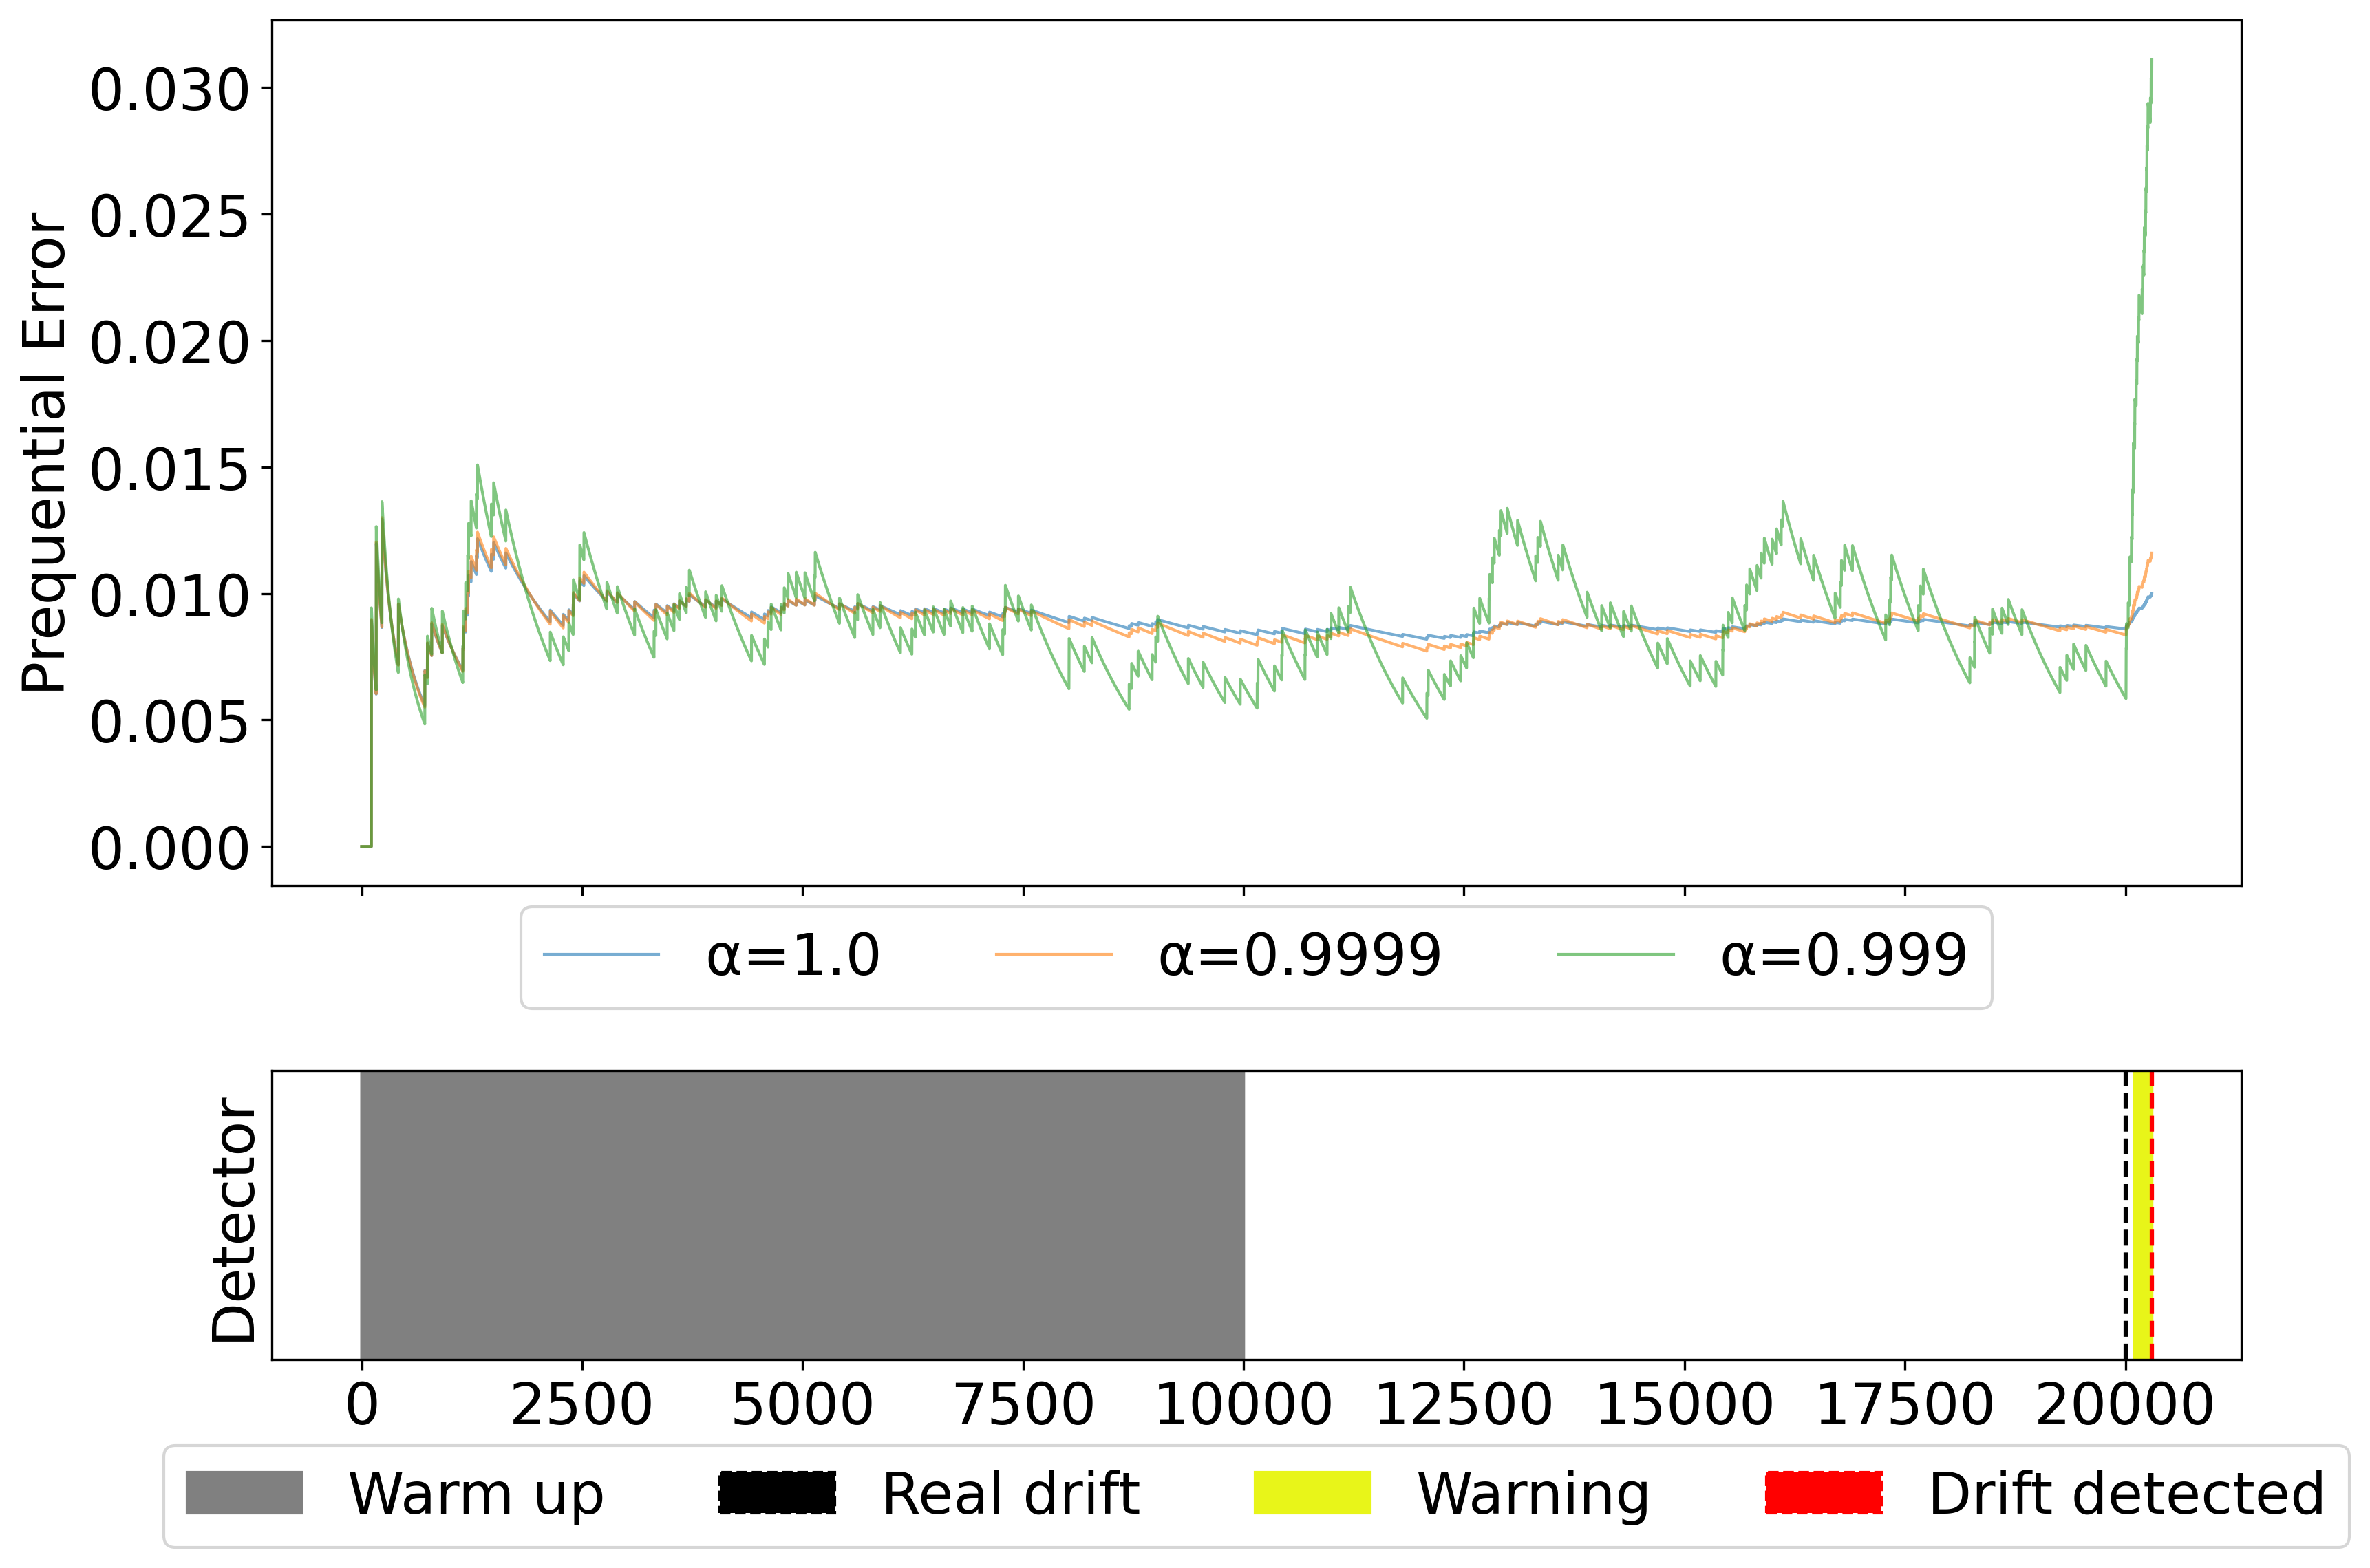

In [47]:
plt.rcParams.update({"font.size": 20})

alpha = 0.6
linewidth = 1.0

fig, ax = plt.subplots(
    nrows=2,
    ncols=1,
    figsize=(12, 8),
    sharex=True,
    dpi=300,
    gridspec_kw={"height_ratios": [3, 1]},
)

for (metric_name, metric_values), linecolor in zip(
    metrics_historic_detector.items(),
    ["#1f77b4", "#ff7f0e", "#2ca02c"],
):
    ax[0].plot(
        metric_values,
        color=linecolor,
        linewidth=linewidth,
        alpha=alpha,
        label=metric_name,
    )

drift_color = "red"
drift_linestyle = "--"
warmup_color = "grey"
warning_color = "#e8f519"
real_drift_color = "black"

for idx in range(0, len(X_warmup)):
    ax[1].axvline(x=idx, color=warmup_color, linewidth=linewidth)

for idx in idx_warning:
    ax[1].axvline(x=idx, color=warning_color, linewidth=linewidth)

for idx in idx_drift:
    ax[1].axvline(x=idx, color=drift_color, linestyle=drift_linestyle, linewidth=1.5)

ax[0].set_ylabel("Prequential Error")
ax[0].legend(
    loc="lower center",
    ncol=3,
    bbox_to_anchor=(0.5, -0.175),
    fancybox=True,
)
ax[1].set_yticks([])
ax[1].set_ylabel("Detector")
drift_path = mpatches.Patch(
    color=drift_color, label="Drift detected", linestyle=drift_linestyle
)
warning_path = mpatches.Patch(color=warning_color, label="Warning")
warmup_path = mpatches.Patch(color=warmup_color, label="Warm up")
real_drift_path = mpatches.Patch(
    color=real_drift_color, label="Real drift", linestyle=drift_linestyle
)
ax[1].axvline(x=20000, color=real_drift_color, linestyle=drift_linestyle, linewidth=1.5)
ax[1].legend(
    handles=[warmup_path, real_drift_path, warning_path, drift_path],
    loc="upper center",
    ncol=4,
    bbox_to_anchor=(0.5, -0.2),
    fancybox=True,
)

fig.tight_layout()
plt.show()

In [57]:
class Circle:
    def __init__(self, radius):
        self.radius = radius

    @property
    def radius(self):
        return self._radius

    @radius.setter
    def radius(self, value):
        if value < 0:
            raise ValueError("Radius cannot be negative")
        self._radius = value

    @property
    def area(self):
        return 3.14 * self._radius ** 2

In [58]:
a = Circle(4)
a.radius

AttributeError: 'Circle' object has no attribute 'radius'